# Inception

In [1]:
import os

HUGGINGFACE_TOKEN = "HF_TOKEN"
os.environ['HF_TOKEN'] = HUGGINGFACE_TOKEN
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HUGGINGFACE_TOKEN

In [2]:
from huggingface_hub import login

login(token=HUGGINGFACE_TOKEN)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!nvidia-smi

Sat Feb  1 00:00:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!python -V

Python 3.11.11


In [5]:
# !pip install -U datasets
!pip install evaluate
!pip install py7zr

!pip install sacrebleu
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatib

In [6]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
ale-py                             0.10.1
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2025.1.27.0.32.44
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.1.0
audioread         

In [8]:
!cp -R "/content/drive/MyDrive/data" .

# Import

In [7]:
import os
import os.path as osp
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from datasets import Dataset, DatasetDict

import time
from tqdm import tqdm

from datasets import load_dataset

In [8]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

# nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# Import the metrics
import evaluate

bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
import torch
from transformers import pipeline, DataCollatorForSeq2Seq
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from transformers import TrainingArguments, Trainer, Seq2SeqTrainingArguments

from transformers import set_seed

In [11]:
seed_value = 5

set_seed(seed_value)
np.random.seed(seed_value)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load pre-trained model

In [13]:
model_name = "openai-community/gpt2"

gpt2 = pipeline(
    "text-generation",
    model=model_name,
    torch_dtype=torch.float16,
    device_map="auto",)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
gpt2.device

device(type='cuda', index=0)

In [15]:
# model context size
gpt2.tokenizer.model_max_length

1024

# Dataset

In [16]:
# function to read the dataset json file
def read_jsonl(path):
    data = []

    with open(path, 'r', encoding='utf-8') as fd:
        for line in fd:
            line_data = json.loads(line)
            data.append(line_data)

    return data


# create Dataset object from dataframe
def read_dataset(dataset_path):
    data = read_jsonl(dataset_path)
    df = pd.DataFrame(data)
    return df


# function to combine trainm test, val data in the same object
def create_combined_dataset(train_data_path,
                            val_data_path,
                            test_data_path):

    train_dataset = read_dataset(train_data_path)
    val_dataset = read_dataset(val_data_path)
    test_dataset = read_dataset(test_data_path)

    dataset = DatasetDict({
        "train": Dataset.from_pandas(train_dataset),
        "validation": Dataset.from_pandas(val_dataset),
        "test": Dataset.from_pandas(test_dataset),
    })

    return dataset


In [17]:
data_fol ="/content/data"
train_path = osp.join(data_fol, "train.jsonl")
val_path = osp.join(data_fol, "validate.jsonl")
test_path = osp.join(data_fol, "test.jsonl")

dataset_original = create_combined_dataset(train_path, val_path, test_path)
dataset_original

DatasetDict({
    train: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 2735
    })
    validation: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 341
    })
    test: Dataset({
        features: ['idx', 'inputs', 'target'],
        num_rows: 343
    })
})

In [18]:
val_dataset = dataset_original["validation"]
test_dataset = dataset_original["test"]

# Prompt Engineering

### Prompt templates & code

In [22]:
# zero_short_prompt_messages = [
#     {"role": "user",
#      "content": "Do the text summarization of the following text:\n\n{}" },
# ]

zero_shot_base_prompt_messages = []

# ********************************************************************

one_shot_example = {
    "text":"Patchy airspace disease is noted within the right middle lobe. Subtle opacities are present within the lingula as well. There is no pneumothorax or pleural effusion. The heart size is normal.",
    "summary": "Patchy right middle lobe and lingular airspace disease compatible with multilobar pneumonia."
}

one_shot_base_prompt_messages = [
    {"role": "user",
     "content": one_shot_example["text"] },
    {"role": "assistant",
    "content": one_shot_example["summary"]},
]

# ********************************************************************

two_shot_example = {
    "text": [ "Patchy airspace disease is noted within the right middle lobe. Subtle opacities are present within the lingula as well. There is no pneumothorax or pleural effusion. The heart size is normal.",
             "Heart size and pulmonary vascularity appears normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Callus or granulomas identified. Left XXXX-A-XXXX remains in XXXX."
    ],
    "summary": [ "Patchy right middle lobe and lingular airspace disease compatible with multilobar pneumonia.",
                "No evidence of active disease."
    ]
}

two_shot_base_prompt_messages = [
    {"role": "user",
     "content": two_shot_example["text"][0] },
    {"role": "assistant",
    "content": two_shot_example["summary"][0] },
    {"role": "user",
     "content": two_shot_example["text"][1] },
    {"role": "assistant",
    "content": two_shot_example["summary"][1] },
]

# ********************************************************************

four_shot_example = {
    "text": [ "Patchy airspace disease is noted within the right middle lobe. Subtle opacities are present within the lingula as well. There is no pneumothorax or pleural effusion. The heart size is normal.",
             "Heart size and pulmonary vascularity appears normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. Callus or granulomas identified. Left XXXX-A-XXXX remains in XXXX.",
              "Stable cardiomegaly. Thoracic aortic atherosclerotic calcifications are noted. There is a prominence of the pulmonary vasculature. No consolidating airspace disease is seen. No pleural effusion or pneumothorax.",
              "Normal heart size and mediastinal contour. Right lung base airspace disease on frontal XXXX. XXXX opacities in the left lung base consistent with atelectasis. No pneumothorax. No pleural effusion. Mild wedge XXXX deformity of T12."

    ],
    "summary": [ "Patchy right middle lobe and lingular airspace disease compatible with multilobar pneumonia.",
                "No evidence of active disease.",
                 "Cardiomegaly and pulmonary vascular congestion.",
                 "Right lung base airspace disease and left base atelectasis."
    ]
}

four_shot_base_prompt_messages = [
    {"role": "user",
     "content": four_shot_example["text"][0] },
    {"role": "assistant",
    "content": four_shot_example["summary"][0] },
    {"role": "user",
     "content": four_shot_example["text"][1] },
    {"role": "assistant",
    "content": four_shot_example["summary"][1] },
    {"role": "user",
     "content": four_shot_example["text"][2] },
    {"role": "assistant",
    "content": four_shot_example["summary"][2] },
    {"role": "user",
     "content": four_shot_example["text"][3] },
    {"role": "assistant",
    "content": four_shot_example["summary"][3] },
]


In [46]:
def generate_prompt(text, model_pipeline, prompt_message_base):

    if len(prompt_message_base)==0: # zero shot
        prompt_pre = "Do the task summarization of the text below:\n\n"
    else:
        prompt_pre = "See the examples below for task summarization.\n\n"
        temp_text = ""
        for dict_obj in prompt_message_base:
            role = dict_obj["role"]
            content = dict_obj["content"]
            # text_temp2 = "ROLE:\n"+role + "\n" + "CONTENT:\n"+content + "\n\n"
            # temp_text += text_temp2

            if role == "user":
                text_temp2 = "TEXT:\n"+content+"\n"
            else:
                text_temp2 = "SUMMARY:\n"+content+"\n\n"

            temp_text += text_temp2



        prompt_pre += temp_text + "Do the task summarization of the text below:\n\n"

    prompt = prompt_pre + text

    return prompt


def generate_summary_from_prompt(prompt, model_pipeline, temperature=0.1, top_k=20, top_p=0.3):

    out_summary = model_pipeline(
        prompt,
        add_special_tokens=True,
        do_sample=True,
        temperature=temperature, top_k=top_k, top_p=top_p,
        pad_token_id=model_pipeline.tokenizer.eos_token_id,
        max_length=760)

    summary = out_summary[0]["generated_text"][len(prompt):]

    return summary


In [35]:
def generate_summary(model_pipeline, dataset, column_text, column_target,
                     prompt_message_base,
                     temperature=0.1, top_k=20, top_p=0.3):

    text_col = dataset[column_text]
    text_ref = dataset[column_target]

    N = len(text_col)
    summary_gen_ll = []
    for i in tqdm(range(N)):
        text = text_col[i]
        prompt = generate_prompt(text, model_pipeline, prompt_message_base)
        summary_gen = generate_summary_from_prompt(prompt, model_pipeline, temperature=temperature, top_k=top_k, top_p=top_p)
        summary_gen_ll.append(summary_gen)

    df = pd.DataFrame({"text":text_col, "reference":text_ref, "summary_gen":summary_gen_ll})

    return df


In [36]:
def evaluate_dataset(predicted_dataset,
                     metric):
    # INPUT:
        # predicted_dataset: dataframe with generated summaries
        # metric: the metric to compute

    N = len(predicted_dataset)

    for i in tqdm(range(0, N)):
        ref = predicted_dataset["reference"][i]
        summ_gen = predicted_dataset["summary_gen"][i]
        summ_gen = summ_gen.replace("<n>", " ")

        metric.add_batch(predictions=[summ_gen], references=[ref])

    score = metric.compute()
    return score


### Zero shot

In [47]:
prompt_base = zero_shot_base_prompt_messages
zero_shot_summ_df = generate_summary(gpt2, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [38:01<00:00,  6.65s/it]


In [48]:
zero_shot_summ_df.to_csv("zero_shot_results.csv", index=False)

In [49]:
scores = evaluate_dataset(zero_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 2747.24it/s]


,0
rouge1,0.004477
rouge2,0.000783
rougeL,0.004425
rougeLsum,0.004408


In [50]:
zero_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,No evidence of pulmonary edema. No evidence o...
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,\n\nThe following are the contours of the XXXX...
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,\n\nThe text below is a summary of the text of...
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,No pneumothorax. No pneumothorax. No pneumoth...
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,No significant changes in the volume of the v...


In [51]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = zero_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

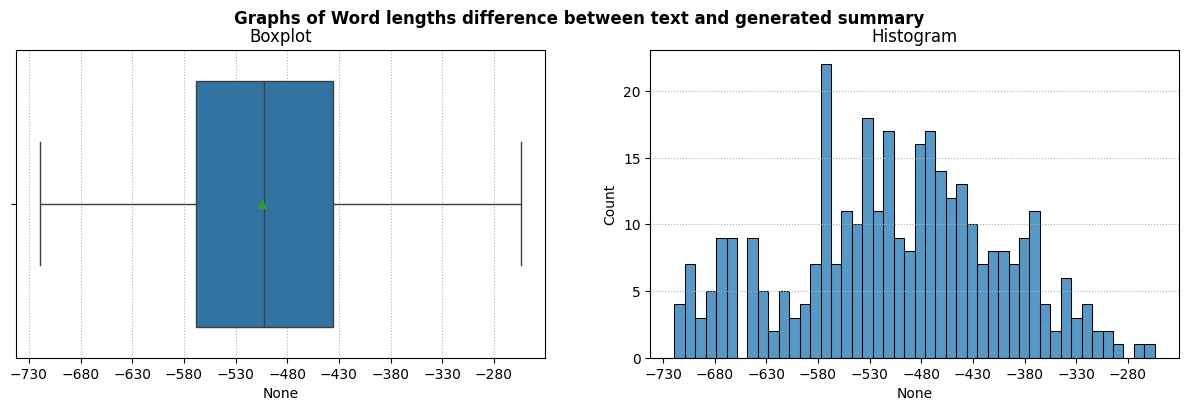

In [64]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

min_val = np.min(word_length_diff_ll)

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=10, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[1].set_title("Histogram")

plt.show()

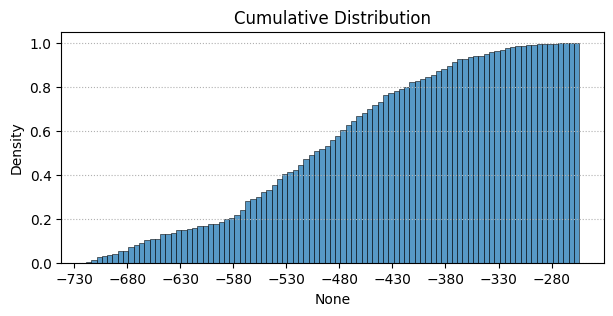

In [67]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
plt.show()

In [68]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  343
Total summaries:  343
Ratio:  1.0


In [69]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(zero_shot_summ_df), total, replace=False)

for i in choice_list:
    text = zero_shot_summ_df.iloc[i]["text"]
    ref = zero_shot_summ_df.iloc[i]["reference"]
    summ_gen = zero_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:   There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is no pulmonary edema. There is n

### One Shot

In [70]:
prompt_base = one_shot_base_prompt_messages
one_shot_summ_df = generate_summary(gpt2, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [33:18<00:00,  5.83s/it]


In [71]:
one_shot_summ_df.to_csv("one_shot_results.csv", index=False)

In [72]:
scores = evaluate_dataset(one_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 3089.72it/s]


,0
rouge1,0.008984
rouge2,0.002939
rougeL,0.008879
rougeLsum,0.007905


In [73]:
one_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,\n\nThe patient is in good health and is in go...
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,\n\nThe patient is not symptomatic.\n\nThe pat...
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,\n\nThe text below is a summary of the results...
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,\n\nThe patient is in good health.\n\nThe pati...
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,\n\nThe text below is a summary of the results...


In [74]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = one_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

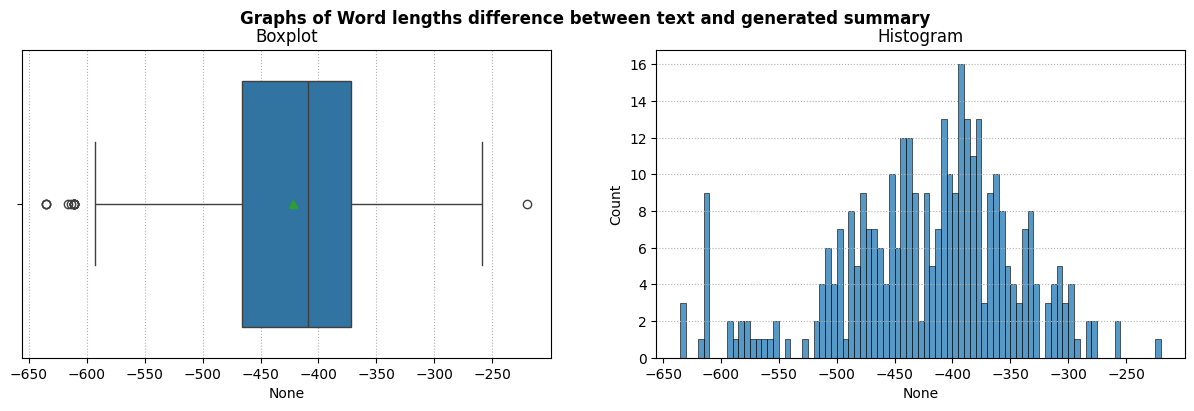

In [75]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

min_val = np.min(word_length_diff_ll)

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range(  min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range(  min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[1].set_title("Histogram")

plt.show()

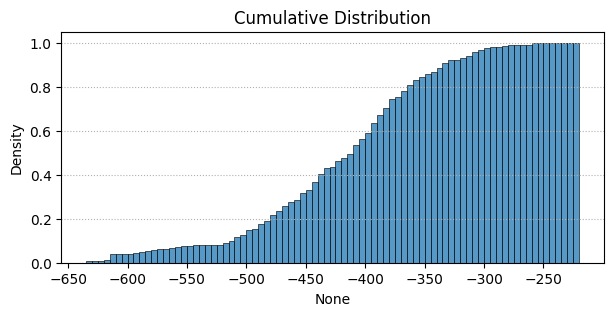

In [76]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range(  min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
plt.show()

In [77]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  343
Total summaries:  343
Ratio:  1.0


In [78]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(one_shot_summ_df), total, replace=False)

for i in choice_list:
    text = one_shot_summ_df.iloc[i]["text"]
    ref = one_shot_summ_df.iloc[i]["reference"]
    summ_gen = one_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:  

The left lung calcified granuloma is a small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small, small,

### Two shot

In [79]:
prompt_base = two_shot_base_prompt_messages
two_shot_summ_df = generate_summary(gpt2, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [29:38<00:00,  5.18s/it]


In [80]:
two_shot_summ_df.to_csv("two_shot_results.csv", index=False)

In [81]:
scores = evaluate_dataset(two_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 3178.05it/s]


,0
rouge1,0.015063
rouge2,0.004713
rougeL,0.014968
rougeLsum,0.013876


In [82]:
two_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,\n\nTEXT:\n\nNo evidence of active disease.\n\...
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,\n\nTEXT:\n\nOpacity within the right middle a...
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,\n\nTEXT:\n\nNo evidence of active disease.\n\...
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,\n\nSUMMARY:\n\nNo evidence of active disease....
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,No pleural effusion. No pleural effusion. No ...


In [83]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = two_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

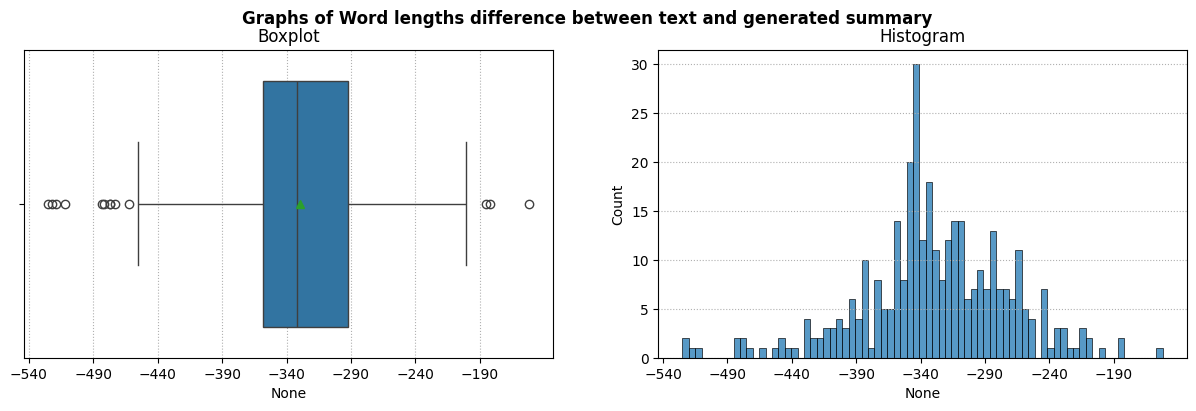

In [84]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

min_val = np.min(word_length_diff_ll)

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[1].set_title("Histogram")

plt.show()

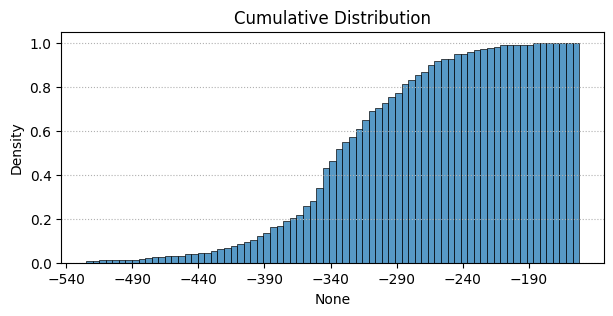

In [85]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
plt.show()

In [86]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  343
Total summaries:  343
Ratio:  1.0


In [87]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(two_shot_summ_df), total, replace=False)

for i in choice_list:
    text = two_shot_summ_df.iloc[i]["text"]
    ref = two_shot_summ_df.iloc[i]["reference"]
    summ_gen = two_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:  

TEXT:

The left-sided air space opacity is normal. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided air space disease.

SUMMARY:

No evidence of active disease.

Do the task summarization of the text below:

The left-sided air space opacity is normal. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided air space disease.

TEXT:

The left-sided air sp

### Four shot

In [88]:
prompt_base = four_shot_base_prompt_messages
four_shot_summ_df = generate_summary(gpt2, test_dataset, "inputs", "target", prompt_base, )

100%|██████████| 343/343 [21:02<00:00,  3.68s/it]


In [89]:
four_shot_summ_df.to_csv("four_shot_results.csv", index=False)

In [90]:
scores = evaluate_dataset(four_shot_summ_df, rouge_metric)
pd.DataFrame.from_dict(scores, orient="index")

100%|██████████| 343/343 [00:00<00:00, 1957.66it/s]


,0
rouge1,0.020295
rouge2,0.005287
rougeL,0.018649
rougeLsum,0.018693


In [91]:
four_shot_summ_df.head()

,text,reference,summary_gen
0,Heart size within normal limits. No focal alve...,No acute cardiopulmonary findings,No pleural effusion. No pleural effusion. No ...
1,Mediastinal contours are normal. Opacity withi...,Opacification of the right middle and lower lo...,\n\nTEXT:\n\nOpacity within the right middle a...
2,"No gross consolidation, atelectasis or infiltr...",1. Negative for acute cardiopulmonary findings.,\n\nTEXT:\n\nCardiomegaly and pulmonary vascul...
3,There is no focal airspace consolidation or pl...,No acute cardiopulmonary abnormality. .,No pleural effusion. No pleural effusion. No ...
4,Heart size and mediastinal contour within norm...,No acute cardiopulmonary abnormality.,No pleural effusion. No pleural effusion. No ...


In [92]:
# get the difference in the no of words in original text and the generated summary
word_length_diff_ll = four_shot_summ_df.apply(lambda row: len(word_tokenize(row["text"]))-len(word_tokenize(row["summary_gen"])),
                                              axis=1 )

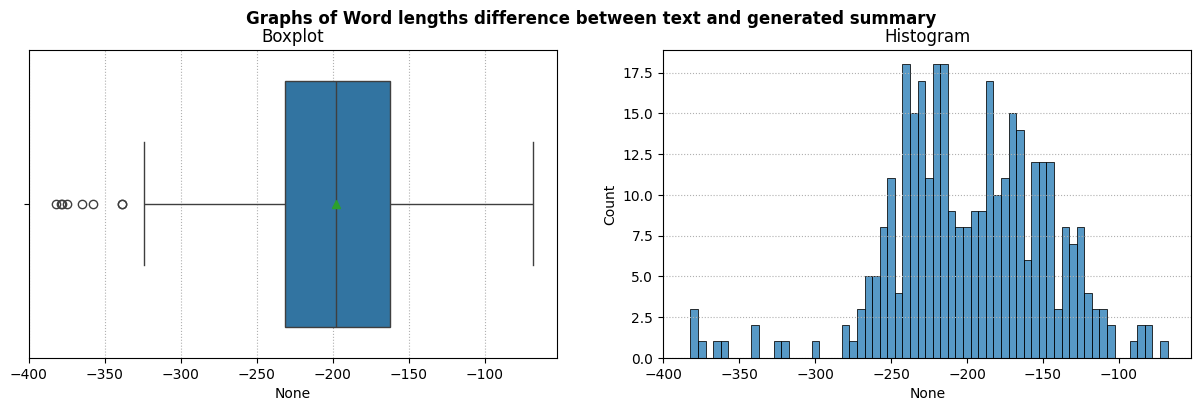

In [93]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("Graphs of Word lengths difference between text and generated summary", fontweight="bold")

min_val = np.min(word_length_diff_ll)

sns.boxplot(x=word_length_diff_ll, showmeans=True, ax=ax[0])
ax[0].grid(axis="x", linestyle="dotted", linewidth=0.8, alpha=1)
ax[0].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[0].set_title("Boxplot")

sns.histplot(x=word_length_diff_ll, binwidth=5, ax=ax[1])
ax[1].grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
ax[1].set_xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
ax[1].set_title("Histogram")

plt.show()

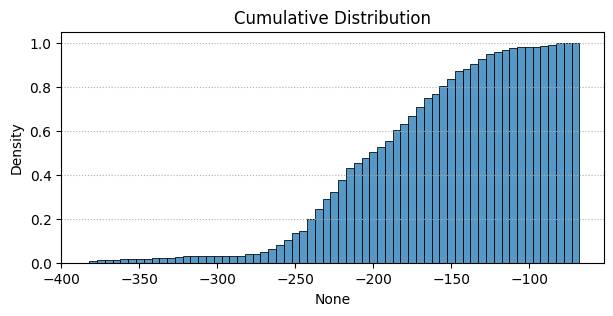

In [94]:
plt.figure(figsize=(7, 3))
plt.title("Cumulative Distribution")
sns.histplot(x=word_length_diff_ll, binwidth=5, kde=False, cumulative=True, stat="density")
plt.grid(axis="y", linestyle="dotted", linewidth=0.8, alpha=1)
plt.xticks( range( min_val-min_val%10-10, np.max(word_length_diff_ll) + 5, 50) )
plt.show()

In [95]:
n1 = np.sum( np.array(word_length_diff_ll) <=0 )
n2 = len(word_length_diff_ll)
print("Total generated summaries with length greater than text: ", n1)
print("Total summaries: ", n2)
print("Ratio: ", n1/n2)

Total generated summaries with length greater than text:  343
Total summaries:  343
Ratio:  1.0


In [96]:
# display some of the generated summaries

total = 5

np.random.seed(5)
choice_list = np.random.choice(len(four_shot_summ_df), total, replace=False)

for i in choice_list:
    text = four_shot_summ_df.iloc[i]["text"]
    ref = four_shot_summ_df.iloc[i]["reference"]
    summ_gen = four_shot_summ_df.iloc[i]["summary_gen"]

    print("TEXT: ", text)
    print("REFERENCE: ", ref)
    print("SUMMARY GEN: ", summ_gen)
    print("\n")

TEXT:  The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided airspace disease.
REFERENCE:  No acute cardiopulmonary disease.
SUMMARY GEN:   No pleural effusion or pneumothorax.

TEXT:

Cardiomegaly and pulmonary vascular congestion.

TEXT:

Normal heart size and mediastinal contour. Right lung base airspace disease on frontal XXXX. XXXX opacities in the left lung base consistent with atelectasis. No pneumothorax. No pleural effusion. Mild wedge XXXX deformity of T12.

SUMMARY:

Right lung base airspace disease and left base atelectasis.

Do the task summarization of the text below:

The left-sided air space opacity to suggest a pneumonia. There is a left lung calcified granuloma noted. There has been resolution of the left-sided air space disease. No pleural effusion or pneumot